# Requirements

In [ ]:
# this line has to be executed only once, you should remove it once the library is installed (but you might also already have it)
!pip install transformers accelerate

# GPU

**Please make sure to check which GPUs are free before loading a model, and only use a GPU that is currently free**!!

You can do this with this command:

In [2]:
!nvidia-smi

Tue Jun  3 15:30:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   35C    P0             43W /  300W |       1MiB /  49140MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Here is an example output:

![Bildschirmfoto 2025-05-07 um 17.46.28.png](<attachment:Bildschirmfoto 2025-05-07 um 17.46.28.png>)
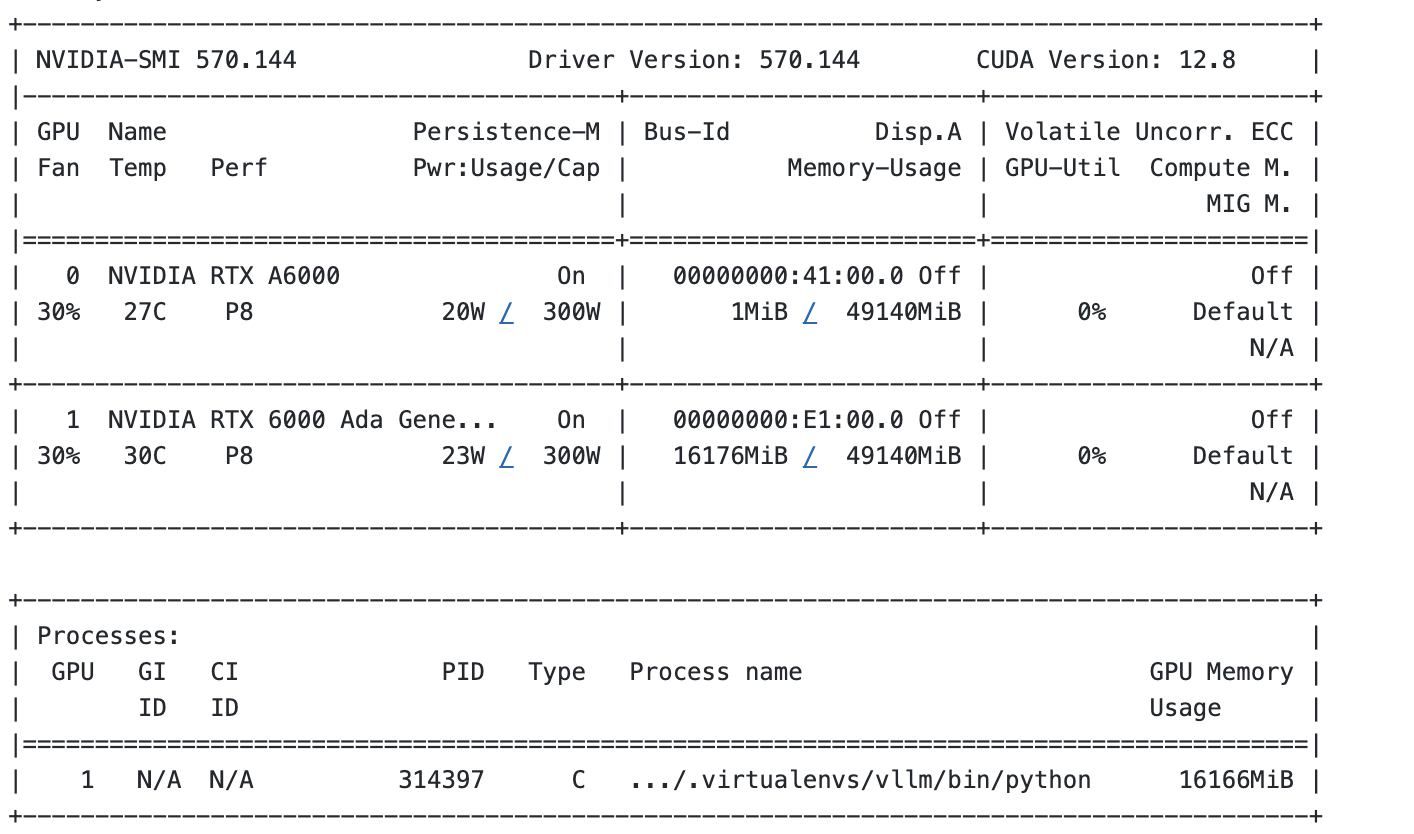

In this list, you can see that GPU 1 is in use (there is a process in the list at the bottom for GPU index 1), but GPU 0 is free (no process with GPU index 0).

You may use the following servers (sometimes, all GPUs are in use):
- `kiwi.ims.uni-stuttgart.de` (this will run all models below, except the 8B version)
- `nandu.ims.uni-stuttgart.de` (this will run all models below, including the 8B version)
- `wiesenweihe.ims.uni-stuttgart.de` (this will run all models below, except the 8B version)
- `kapweihe.ims.uni-stuttgart.de` (this will run all models below, including the 8B version)
- `kornweihe.ims.uni-stuttgart.de` (this will run all models below, except the 8B version)

Everything you save to `/mount/...` is accessible from any of these servers, so if one server is full just move to another.
To add a new server connection to your vscode, open the remote explorer and click the "+" icon:

![alt text](image.png)

**IMPORTANT**: After you finish a session, **please make sure to free the GPU memory again**, so that other people can use it. For this, just click "Restart" in the jupyter notebook:

![Bildschirmfoto 2025-05-07 um 17.06.16.png](<attachment:Bildschirmfoto 2025-05-07 um 17.06.16.png>)
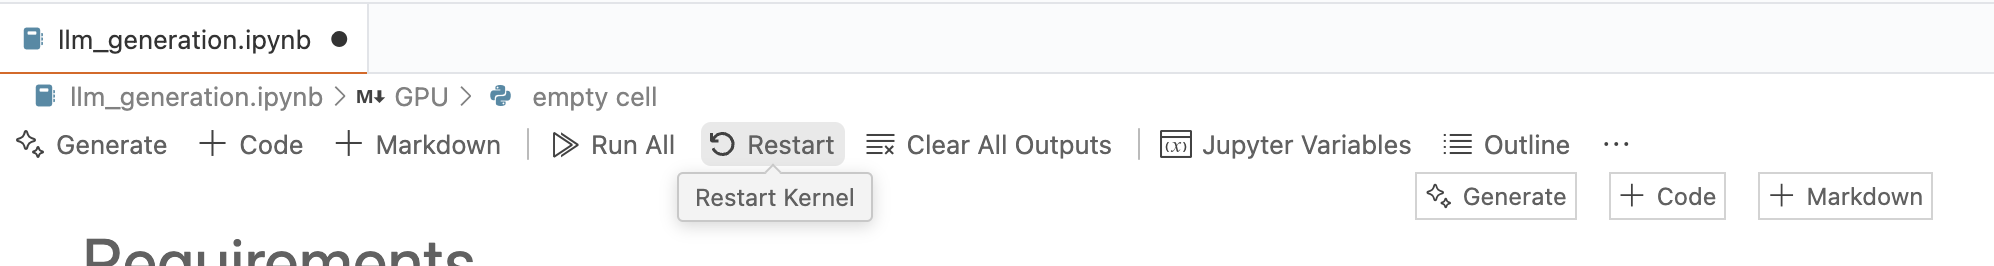

## How to select a GPU

Once you found a server with a free GPU, 
please make sure to execute this every time you start a session to restrict the access of the models to this GPU (using the GPU's id), 
otherwise you might accidentally block all GPUs for other people:

In [3]:
import os
your_gpu_id = "7"
os.environ["CUDA_VISIBLE_DEVICES"] = your_gpu_id

you can verify that it worked by calling the following lines (if they return 1, that means that you have successfully limited access to a single GPU)

In [4]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)

print(torch.cuda.device_count())
print(torch.cuda.get_device_capability(0))

CUDA available: True
CUDA version: 12.6
PyTorch version: 2.7.0+cu126
1
(8, 6)


# Loading a model

The following code will download the specified model from the huggingface hub, or use an already downloaded version if available.
If you download new models, you should specify a directory on your mount folder, otherwise it will try to download into your home folder (which doens't have enough spacce).

You can start with the models we downloaded for you, by using my model directory cache (you only have read access to this directory, so for downloading new ones change it to your folder):

In [3]:
MODEL_CACHE_DIR = '/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/llm/students'
os.environ['TRANSFORMERS_CACHE'] = MODEL_CACHE_DIR

The following lines will load a model (need to be executed only once per session).

We already pre-loaded a model in 4 different sizes for your first research question.
To change between the models, just uncomment another `model_name` line and re-run the cell (or, if the memory wasn't released and you get an out of memory error, just restart the entire notebook kernel as described above).

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed ,pipeline

# The model name points to a repository on huggingface, where it will load the model and configuration from, e.g.: https://huggingface.co/Qwen/Qwen3-0.6B
model_name = "Qwen/Qwen3-0.6B"
# model_name = "Qwen/Qwen3-1.7B"
# model_name = "Qwen/Qwen3-4B"
# model_name = "Qwen/Qwen3-8B"


# load the tokenizer and the model (you can leave this block unchanged)
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=MODEL_CACHE_DIR)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    cache_dir=MODEL_CACHE_DIR
).to("cuda:0")

/home/users2/vaethdk/.virtualenvs/vllm/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users2/vaethdk/.virtualenvs/vllm/lib64/python3.12/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
# This method is for:
# 1. converting the queries into the right template format
# 2. tokenizing the promt text
# 3. converting the tokens to token ids
# 4. running the token ids through the model, generating output token ids
# 5. converting the output token ids back to text tokens
def generate(system_prompt: str, user_prompt: str, temperature: float = 0.7, seed: int = 42, enable_thinking=False) -> str:
    # set a random seed for reproducability (otherwise, calling generation twice can result in different texts)
    set_seed(seed=seed)

    # convert the prompts into the correct template
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking
    )
    # convert prompt texts to tokens, move the token ids to the GPU
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    # generate the output token ids
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 
    # convert the output token ids to text tokens
    content = tokenizer.decode(output_ids, skip_special_tokens=True)
    return content

# Generate Text

Once the model is loaded, you can play around with prompts by changing the content in following lines (and re-running them).

In [6]:
output = generate(system_prompt="Please answer the user question in a faithful way.",
                  user_prompt="What is 2 + 2?",
                  temperature=0.7)
print(output)

2 + 2 = 4.
